# EDA and Modeling of vm traces dataset

This notebook explores and models the relationship between network throughput and memory usage in a large vm dataset collected from a distributed datacenter from Bitbrains, which is a service provider that specializes in managed hosting and business computation for enterprises. [See here](http://gwa.ewi.tudelft.nl/datasets/gwa-t-12-bitbrains)

In [1]:
import matplotlib.pyplot as plt
import os
import pandas as pd
VMS = 10

/Users/domenicrosati/.pyenv/versions/3.6.4/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)


In [2]:
import logging
import timber

logging.basicConfig(level=logging.INFO)
logger = logging.getLogger(__name__)

timber_handler = timber.TimberHandler(api_key=os.getenv('TIMBER_API_KEY'), level=logging.INFO, raise_exceptions=True)
logger.addHandler(timber_handler)

## Load and preprocess traces dataset

/Users/domenicrosati/.pyenv/versions/3.6.4/lib/python3.6/site-packages/ipykernel_launcher.py:3: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  This is separate from the ipykernel package so we can avoid doing imports until


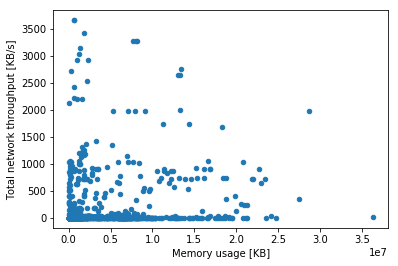

In [3]:
trace_dfs = [
    pd.read_csv(os.path.join('..', 'data', 'traces', trace_path), delimiter=';\t')
    for trace_path in os.listdir(os.path.join('..', 'data', 'traces'))[:VMS]
]

trace = pd.concat(trace_dfs)

trace['Total network throughput [KB/s]'] = trace['Network received throughput [KB/s]'].add(trace['Network transmitted throughput [KB/s]'])
trace.plot.scatter('Memory usage [KB]', 'Total network throughput [KB/s]')

## Train a RandomForestRegressor Model from Scikit Learn

/Users/domenicrosati/.pyenv/versions/3.6.4/lib/python3.6/site-packages/sklearn/ensemble/weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d
INFO:__main__:Random Forest Regressor
INFO:__main__:Random Forest Regressors score was: 0.472145


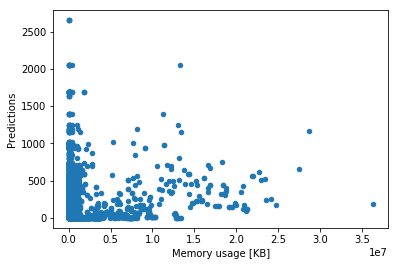

In [4]:
from sklearn.ensemble import RandomForestRegressor

logger.info('Random Forest Regressor')
regressor = RandomForestRegressor(max_depth=10, random_state=1)
regressor.fit([[t] for t in trace['Memory usage [KB]']], trace['Total network throughput [KB/s]'].values)

trace['Predictions'] = pd.Series([regressor.predict([[t]])[0] for t in trace['Memory usage [KB]']])
trace.plot.scatter('Memory usage [KB]', 'Predictions')
logger.info('Random Forest Regressors score was: %f', regressor.score([[t] for t in trace['Memory usage [KB]']], trace['Total network throughput [KB/s]'].values))

## Normalize data for neural networks and split for train/test

In [5]:
from sklearn.preprocessing import StandardScaler
sc = StandardScaler()
x = sc.fit_transform(trace['Memory usage [KB]'].values.reshape(-1, 1))
y = sc.fit_transform(trace['Total network throughput [KB/s]'].values.reshape(-1, 1))
x_train = x[:int(len(x)/2)]
y_train = y[:int(len(y)/2)]
x_test = x[int(len(x)/2):]
y_test = y[int(len(y)/2):]

## Train simple NN in Keras

Using TensorFlow backend.
INFO:__main__:Simple Keras NN


60243/60243 [==============================] - 1s 13us/step


INFO:__main__:Simple Keras NN: Test score: 0.4017013366682913
INFO:__main__:Simple Ketas NN: Test accuracy: 0.0


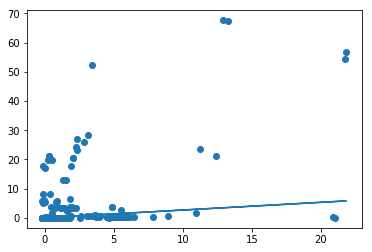

In [6]:
from keras.models import Sequential
from keras.layers import Dense, Dropout

logger.info('Simple Keras NN')
model = Sequential()
model.add(Dense(1, kernel_initializer='normal'))
model.add(Dense(1, kernel_initializer='normal'))
model.compile(loss='mse', optimizer='adam', metrics=['accuracy'])
for step in range(10000):
    cost = model.train_on_batch(x_train, y_train)

score, acc = model.evaluate(x_test, y_test)
logger.info('Simple Keras NN: Test score: {}'.format(score))
logger.info('Simple Ketas NN: Test accuracy: {}'.format(acc))
y_pred = model.predict(x_test)
plt.scatter(x_test, y_test)
plt.plot(x_test, y_pred)
plt.show()

## Train Simple Linear Regressor Model in Tensorflow

INFO:__main__:TF Estimator Linear Regressor
INFO:tensorflow:Using default config.
INFO:tensorflow:Using config: {'_model_dir': '/var/folders/zt/5_ksy7fn3lj3vh_9fkfgf9mc0000gn/T/tmp87raaoy2', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': None, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_train_distribute': None, '_device_fn': None, '_service': None, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x1126809b0>, '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op

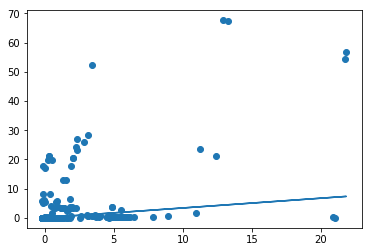

In [7]:
import tensorflow as tf

logger.info('TF Estimator Linear Regressor')
memory_col = tf.feature_column.numeric_column('memory')
estimator = tf.estimator.LinearRegressor(feature_columns=[memory_col])

# create training input function
training_input_fn = tf.estimator.inputs.numpy_input_fn(x={'memory': x_train},
                                                    y=y_train,
                                                    batch_size=32,
                                                    shuffle=False,
                                                    num_epochs=1)

# create testing input function
eval_input_fn = tf.estimator.inputs.numpy_input_fn(x={'memory': x_test},
                                                    y=y_test,
                                                    batch_size=32,
                                                    shuffle=False,
                                                    num_epochs=1)
estimator.train(training_input_fn, steps=2000)

pred = list(estimator.predict(input_fn = eval_input_fn))
pred = [p['predictions'][0] for p in pred]

logger.info('TF Estimator sores were {}'.format(estimator.evaluate(input_fn = eval_input_fn)))
y_pred = pred
plt.scatter(x_test, y_test)
plt.plot(x_test, y_pred)
plt.show()